In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from libpysal.weights import fuzzy_contiguity
import json
import dask
from dask import delayed, dataframe as dd
from dask.distributed import Client, LocalCluster
from dask.graph_manipulation import bind
import bokeh
import dask_geopandas as dgpd
from dask.diagnostics import ProgressBar
import glob
import dask.bag as db
from itertools import chain
import json
import pickle

/tmp/ipykernel_4659/3066450523.py:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
# %%time
# for ch in range(10):
#     tess = gpd.read_parquet(f'./out/singapore/tess_chunk_{int(ch)}.pq')
#     tess = tess.reset_index(drop=True)
#     filler = pd.Series(range(len(tess[tess.uID.isna()])), index=tess[tess.uID.isna()].index) + ch * 100_000_000
#     tess['uID'] = tess.uID.fillna(filler)
#     tess.to_parquet(f'./out/singapore/tess_chunk_{int(ch)}.pq')

In [3]:
with open('./out/singapore/clustertess.json', 'r') as f:
    includes_dict = json.load(f)

In [4]:
chunks = gpd.read_parquet('./out/singapore/clusters.pq')

In [5]:
w = fuzzy_contiguity(chunks, buffering=True, buffer=1000)

/home/virgilxw/miniconda3/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 3.
  warnings.warn(message)


<Axes: >

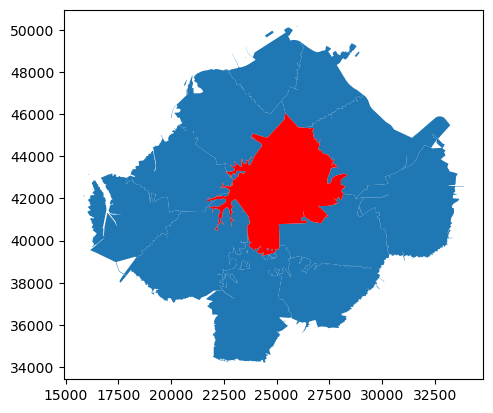

In [6]:
ax = chunks.loc[w.neighbors[2]].plot()
chunks.loc[[2]].plot(ax=ax, color='r')

In [7]:
cluster = LocalCluster(threads_per_worker=2,
                n_workers=8, memory_limit='30GB')

client = Client(cluster)

2023-03-22 00:35:45,741 - distributed.worker_memory - WARNING - Ignoring provided memory limit 30GB due to system memory limit of 15.58 GiB
2023-03-22 00:35:45,744 - distributed.worker_memory - WARNING - Ignoring provided memory limit 30GB due to system memory limit of 15.58 GiB
2023-03-22 00:35:45,746 - distributed.worker_memory - WARNING - Ignoring provided memory limit 30GB due to system memory limit of 15.58 GiB
2023-03-22 00:35:45,748 - distributed.worker_memory - WARNING - Ignoring provided memory limit 30GB due to system memory limit of 15.58 GiB
2023-03-22 00:35:45,751 - distributed.worker_memory - WARNING - Ignoring provided memory limit 30GB due to system memory limit of 15.58 GiB
2023-03-22 00:35:45,754 - distributed.worker_memory - WARNING - Ignoring provided memory limit 30GB due to system memory limit of 15.58 GiB
2023-03-22 00:35:45,756 - distributed.worker_memory - WARNING - Ignoring provided memory limit 30GB due to system memory limit of 15.58 GiB
2023-03-22 00:35:45,

In [8]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 16,Total memory: 124.66 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44395,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 124.66 GiB
Comm: tcp://127.0.0.1:34243,Total threads: 2
Dashboard: http://127.0.0.1:46041/status,Memory: 15.58 GiB
Nanny: tcp://127.0.0.1:33179,


In [9]:
def duplicates(tessellation):

    # Check for duplicates based on UID
    duplicates = tessellation[tessellation.duplicated(subset='uID', keep=False)]

    # duplicates.to_file( "./out/" + place + 'errors.shp', driver='ESRI Shapefile')

    # Print the duplicate rows
    if len(duplicates) > 0:
        raise Exception("Tesselation: Duplicate UID entries:")
    elif (tessellation["uID"].isnull().values.any()):
        raise Exception("uID column include invalid entries")
    else:
        print("combined_chunk no problems")
        return 0

In [10]:
queen_out = {}

@delayed
def neigh_look(cell_id, main_chunk_ids, combined_chunks):
    cell_poly = combined_chunks.loc[combined_chunks['uID'] == cell_id]
    neighbours = combined_chunks[~combined_chunks.geometry.disjoint(cell_poly)]
    return neighbours.uID.tolist()

def expand_one_order(main_chunk_ids, added_cells_ids, order, combined_chunks):
    if order == 0:
        return main_chunk_ids
    
    if len(added_cells_ids) == 0:
        added_cells_ids = main_chunk_ids

    results = set(main_chunk_ids)

    future = []

    combined_chunks = delayed(combined_chunks)
    
    delayed_objs = []

    for cell_id in added_cells_ids:
        delayed_objs.append(neigh_look(cell_id, main_chunk_ids, combined_chunks))
            
    new_results = dask.compute(*delayed_objs)

    for entry in list(chain(*new_results)):
        results.add(entry)

    delayed_objs = []

    print("compute done this wave")

    neighbouring_cells = list(results)

    expanded_cells = [cell for cell in neighbouring_cells if cell not in main_chunk_ids]
    print("cells added this wave", expanded_cells)
    
    return expand_one_order(expanded_cells, neighbouring_cells, order-1, combined_chunks)
        
def process_chunk(n1, w, order):
    main_chunk = gpd.read_parquet(f"./out/singapore/tess_chunk_{int(n1)}.pq")
    combined_chunks = main_chunk

    main_chunk_ids = list(main_chunk['uID'])
    results = []

    for n2 in w.neighbors[n1]:
        neigh_chunk = gpd.read_parquet(f"./out/singapore/tess_chunk_{int(n2)}.pq")
        combined_chunks = combined_chunks.append(neigh_chunk)

    duplicates(combined_chunks)

    combined_chunks = combined_chunks.reindex()

    delayed_objs = expand_one_order(main_chunk_ids, list(), order, combined_chunks)
    
    # [neigh_look_0(chunk_id, main_chunk_ids, 0, combined_chunks) for chunk_id in main_chunk_ids]

    print("scheduling done")

    # Compute the delayed objects in parallel
    results = dask.compute(*delayed_objs)

    # return results

# for n1 in tqdm(range(10), total=10):
#     queen_out[n1] = process_chunk(n1)

file_pattern = "./out/singapore/tess_chunk_*.pq"
file_list = glob.glob(file_pattern)
num_files = len(file_list)

# combined_chunks=[]
# delayed_tasks = []
# for n1 in range(num_files):
#     delayed_task = process_chunk(n1, w, combined_chunks)
#     delayed_tasks.append(delayed_task)

#     results = delayed_tasks

for n1 in tqdm(range(num_files)):
    queen_out[n1] = process_chunk(n1, w, 3)
    queen_out.to_parquet(f"./out/singapore/queen_{int(n1)}.pq")


  0%|          | 0/46 [00:00<?, ?it/s]

combined_chunk no problems


2023-03-22 00:36:02,314 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-03-22 00:36:02,769 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-03-22 00:36:03,168 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-03-22 00:36:03,568 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-03-22 00:36:04,148 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-03-22 00:36:04,667 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-03-22 00:36:05,128 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-03-22 00:36:05,598 - distributed.utils_perf - WARNING - full garbage collections took

In [ ]:
cluster.close()
client.shutdown()


In [ ]:
queen_out.to_parquet("./out/singapore/queen_areas.pq")